# Base Case: Circular Orbit of Radius 1 AU, Period 1 Year

Create synthetic data for the simplest base case: a circular orbit of radius 1.

Can think of this as approximating the earth: radius = 1 AU, period = 1 year, mass of sun $m_0$ = 1 solar mass

\begin{align}
x(t) &= \cos(\omega t) \\
y(t) &= \sin(\omega t) \\
\omega &= 2 \pi
\end{align}

Taking two derivatives
\begin{align}
\ddot{x}(t) = -\omega^2 x(t)\\
\ddot{y}(t) = -\omega^2 y(t)
\end{align}

Equating the acceleration $\omega^2 r$ to $G \cdot m_0 / r^2$ for $r=1$ in the case of earth, we can see that in these units the gravitational constant $G$ is
$$G = 4 \pi^2$$

Further we can see that for a planet in a circular orbit with radius $r$, the angular frequency will satisfy
$$ \omega^2 = G m_0 / r^3$$
This is a special case of Kepler's third law.

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

# Local imports
import utils

In [2]:
# Grow GPU memory
utils.gpu_grow_memory()

# Plot style 
utils.plot_style()

In [3]:
def make_traj_r2bc(r, theta0, n_years):
    """
    Make an array of training data points for the restricted 2 body circular problem.
    Creates one trajectory with the same initial configuration.
    INPUTS:
    r: The radius of the orbit in AU
    theta0: the angle of the planet in the ecliptic at time 0 years
    n_years: the number of years of data to simulate
    RETURNS:
    input_dict: a dictionary with the input fields t, q0, v0
    output_dict: a dictionary with the output fields q, v, a
    """
    # The sample frequency is 365 per year (dt approximately = 1 day)
    sample_freq = 365
    # Number of samples including both start and end
    N = sample_freq*n_years + 1
    # Array of sample times at the specified frequency over the specified length of time
    t = np.arange(N, dtype=np.float32) / sample_freq

    # The gravitational constant in units of (AU, years, solar_mass)
    G = (2.0 * np.pi)**2
    # The mass of the sun in this coordinate system
    m0 = 1.0
    # The gravitational coefficient G*(m0 + m1) for the restricted two body problem in these units
    mu = G * m0

    # Set the angular frequency omega based on the radius using the relationship
    # mu = omega^2 r^3 --> omega = sqrt(mu / r^3)
    omega = np.sqrt(mu / r**3)
    # Theta is offset by theta0
    theta = (omega * t) + theta0

    # Compute qx and qy from r and theta; wrap into position q
    qx = r*np.cos(theta, dtype=np.float32)
    qy = r*np.sin(theta, dtype=np.float32)
    q = np.stack([qx, qy], axis=1)
    
    # Compute vx and vy; wrap into velocity v
    vx = -omega * qy
    vy = +omega * qx
    v = np.stack([vx, vy], axis=1)

    # Compute ax and ay; wrap into acceleration a
    ax = -omega**2 * qx
    ay = -omega**2 * qy
    a = np.stack([ax, ay], axis=1)

    # Repeat vectors for the initial position q0
    qx0 = np.ones(N) * qx[0]
    qy0 = np.ones(N) * qy[0]
    q0 = np.stack([qx0, qy0], axis=1)
    
    # Repeat vectors for the initial velocity v0
    vx0 = np.ones(N) * vx[0]
    vy0 = np.ones(N) * vy[0]
    v0 = np.stack([vx0, vy0], axis=1)
    
    # Assemble the input dict
    inputs = {
        't': t,
        'q0': q0,
        'v0': v0}

    # Assemble the output dict
    outputs = {
        'q': q,
        'v': v,
        'a': a,
        # also include the initial conditions, which should be recovered
        'q0_rec': q0,
        'v0_rec': v0}
    
    # Return the dicts
    return (inputs, outputs)

In [4]:
def make_train_r2bc(n_traj: int, n_years: int, r_min: float = 0.25, r_max: float = 32.0, seed = 42):
    """
    Make a set of training data for the restricted two body problem
    INPUTS:
    n_traj: the number of trajectories to sample
    n_years: the number of years for each trajectory, e.g. 2
    r_min: minimal distance in AU, e.g. 0.25
    r_max: maximal distance in AU, e.g. 32.0    
    """
    # The sample frequency is 365 per year (dt approximately = 1 day)
    sample_freq = 365
    # Number of samples including both start and end in each trajectory
    traj_size = sample_freq*n_years + 1
    # Total size of the output
    n_rows = n_traj * traj_size

    # Initialize six arrays for the data
    vec_shape = (n_rows, 2)
    t = np.zeros(n_rows, dtype=np.float32)
    q0 = np.zeros(vec_shape, dtype=np.float32)
    v0 = np.zeros(vec_shape, dtype=np.float32)
    q = np.zeros(vec_shape, dtype=np.float32)
    v = np.zeros(vec_shape, dtype=np.float32)
    a = np.zeros(vec_shape, dtype=np.float32)
    
    # Set random seed for reproducible results
    np.random.seed(seed=seed)

    # Sample the trajectories
    for i in range(n_traj):
        # Sample r
        r = np.random.uniform(low=r_min, high=r_max)
        # Sample theta0
        theta0 = np.random.uniform(low=-np.pi, high=np.pi)
        # Generate one trajectory
        inputs, outputs = make_traj_r2bc(r=r, theta0=theta0, n_years=n_years)
        
        # Range of rows for this trajectory
        j0 = (i+0) * traj_size
        j1 = (i+1) * traj_size
        # Copy results into main arrays
        t[j0:j1] = inputs['t']
        q0[j0:j1, :] = inputs['q0']
        v0[j0:j1, :] = inputs['v0']
        q[j0:j1, :] = outputs['q']
        v[j0:j1, :] = outputs['v']
        a[j0:j1, :] = outputs['a']

    # Assemble the input dict
    inputs = {
        't': t,
        'q0': q0,
        'v0': v0}

    # Assemble the output dict
    outputs = {
        'q': q,
        'v': v,
        'a': a,
        # also include the initial conditions, which should be recovered
        'q0_rec': q0,
        'v0_rec': v0}
    
    # Return the dicts
    return (inputs, outputs)

In [5]:
def plot_orbit_q(data):
    """Plot the orbit position in a training sample"""
    # Unpack data
    t = data['t']
    q = data['q']
    qx = q[:, 0]
    qy = q[:, 1]
    # Compute the distance r
    r = np.linalg.norm(q, axis=1)

    # Plot the x and y coordinate
    fig, ax = plt.subplots(figsize=[16, 9])
    ax.set_title('Orbit Position')
    ax.set_xlabel('t - years')
    ax.set_ylabel('q - AU')
    ax.set_xticks(np.arange(0.0, np.max(t)+0.25, 0.25))
    ax.plot(t, qx, color='b', label='qx')
    ax.plot(t, qy, color='r', label='qy')
    ax.plot(t, r,  color='purple', label='r')
    ax.grid()
    ax.legend()
    
    return fig, ax

In [6]:
def plot_orbit_v(data):
    """Plot the orbit velocity in a training sample"""
    # Unpack data
    t = data['t']
    v = data['v']
    vx = v[:, 0]
    vy = v[:, 1]
    spd = np.linalg.norm(v, axis=1)
    
    # Plot the x and y coordinate
    fig, ax = plt.subplots(figsize=[16, 9])
    ax.set_title('Orbit Velocity')
    ax.set_xlabel('t - years')
    ax.set_ylabel('v - AU / year')
    ax.set_xticks(np.arange(0.0, np.max(t)+0.25, 0.25))
    ax.plot(t, vx, color='b', label='vx')
    ax.plot(t, vy, color='r', label='vy')
    ax.plot(t, spd, color='purple', label='spd')
    ax.grid()
    ax.legend()

    return fig, ax

In [7]:
def plot_orbit_a(data):
    """Plot the orbit acceleration in a training sample"""
    # Unpack data
    t = data['t']
    a = data['a']
    ax = a[:, 0]
    ay = a[:, 1]
    acc = np.linalg.norm(a, axis=1)
    
    # Plot the x and y coordinate
    # Name the axes object ax_ rather than ax to avoid a name collision with the x component of acceleration, ax
    fig, ax_ = plt.subplots(figsize=[16, 9])
    ax_.set_title('Orbit Acceleration')
    ax_.set_xlabel('t - years')
    ax_.set_ylabel('a - $AU / year^2$')
    ax_.set_xticks(np.arange(0.0, np.max(t)+0.25, 0.25))
    ax_.plot(t, ax, color='b', label='ax')
    ax_.plot(t, ay, color='r', label='ay')
    ax_.plot(t, acc, color='purple', label='acc')
    ax_.grid()
    ax_.legend()

    return fig, ax_

In [8]:
def plot_orbit_energy(data):
    """Plot the orbit energy in a training sample"""
    # Unpack data
    t = data['t']
    q = data['q']
    v = data['v']
    r = np.linalg.norm(q, axis=1)
    spd = np.linalg.norm(v, axis=1)
    
    # Compute the kinetic energy over m1
    T = 0.5 * spd * spd
    
    # Compute the potential energy over m1
    mu = (2.0 * np.pi)**2
    U = -mu / r
    
    # The total energy
    E = T + U
    
    # Plot the x and y coordinate
    fig, ax = plt.subplots(figsize=[16, 9])
    ax.set_title('Orbit Energy')
    ax.set_xlabel('t - years')
    ax.set_ylabel('Energy / m1 in $(au/year)^2$')
    ax.set_xticks(np.arange(0.0, np.max(t)+0.25, 0.25))
    ax.plot(t, T, color='b', label='T')
    ax.plot(t, U, color='r', label='U')
    ax.plot(t, E, color='purple', label='E')
    ax.grid()
    ax.legend()

    return fig, ax

In [91]:
# One trajectory of earth for plotting
inputs_earth, outputs_earth = make_traj_r2bc(r=1, theta0=0, n_years=2)

# Combined dict
data_earth = {**inputs_earth, **outputs_earth}

In [92]:
# Generate inputs and outputs for the earth's orbit
inputs_earth_trn, outputs_earth_trn = make_train_r2bc(n_traj=100, n_years=2, r_min=1.0, r_max=1.0, seed=42)
inputs_earth_val, outputs_earth_val = make_train_r2bc(n_traj=20, n_years=2, r_min=1.0, r_max=1.0, seed=43)
inputs_earth_tst, outputs_earth_tst = make_train_r2bc(n_traj=20, n_years=2, r_min=1.0, r_max=1.0, seed=44)

In [93]:
# Generate inputs and outputs for the earth's orbit
inputs_trn, outputs_trn = make_train_r2bc(n_traj=10000, n_years=2, r_min=0.25, r_max=32.0, seed=42)
inputs_val, outputs_val = make_train_r2bc(n_traj=2000, n_years=2, r_min=0.25, r_max=32.0, seed=43)
inputs_tst, outputs_tst = make_train_r2bc(n_traj=2000, n_years=2, r_min=0.25, r_max=32.0, seed=44)

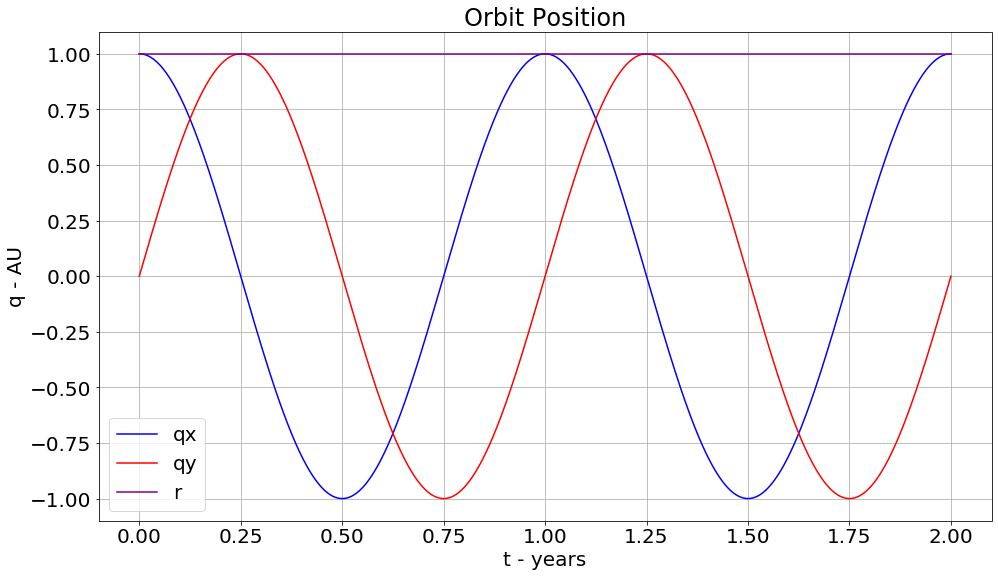

In [94]:
fig, ax = plot_orbit_q(data_earth)

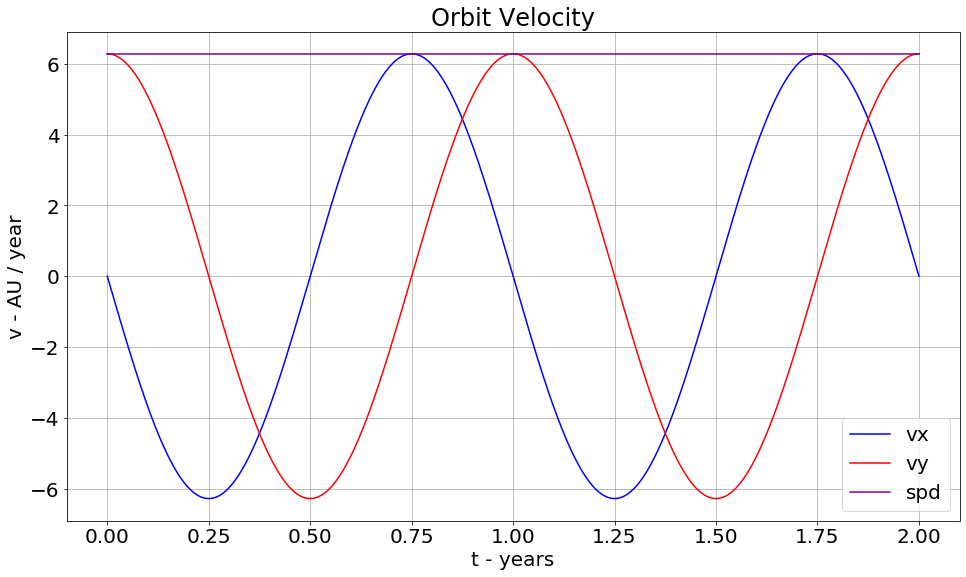

In [95]:
fig, ax = plot_orbit_v(data_earth)

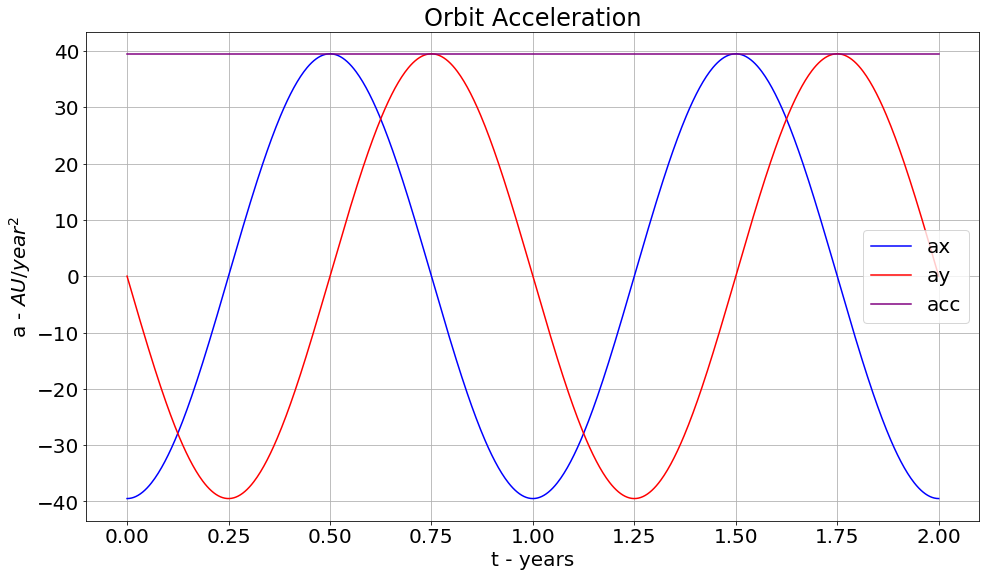

In [96]:
fig, ax = plot_orbit_a(data_earth)

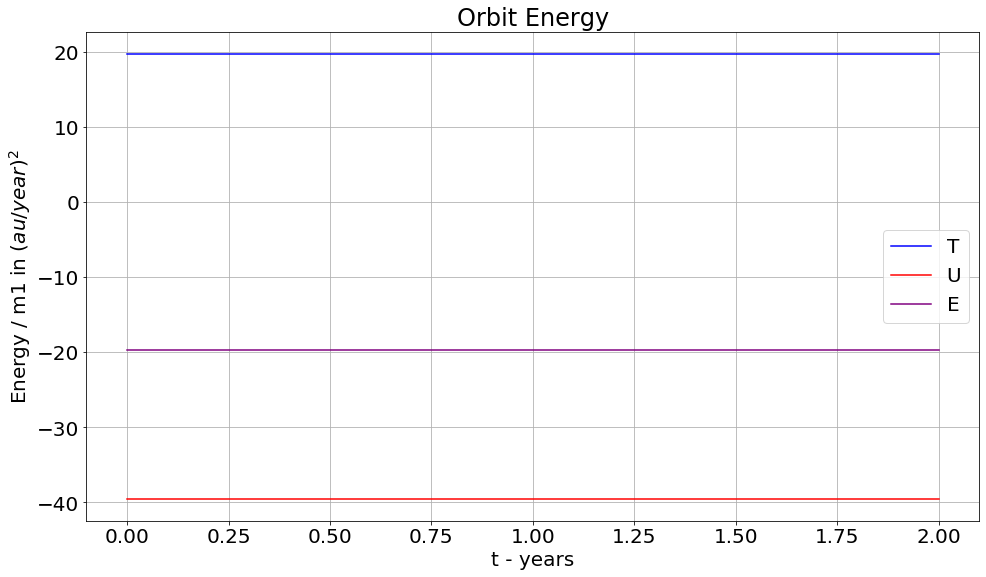

In [97]:
fig, ax = plot_orbit_energy(data_earth)

In [98]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn = tf.data.Dataset.from_tensor_slices((inputs_earth_trn, outputs_earth_trn))
ds_earth_val = tf.data.Dataset.from_tensor_slices((inputs_earth_val, outputs_earth_val))
ds_earth_tst = tf.data.Dataset.from_tensor_slices((inputs_earth_tst, outputs_earth_tst))

# Set buffer and batch sizes
buffer_size = 16536
batch_size = 256

# Shuffle and batch data sets
ds_earth_trn = ds_earth_trn.shuffle(buffer_size=buffer_size).batch(batch_size)
ds_earth_val = ds_earth_val.shuffle(buffer_size=buffer_size).batch(batch_size)
ds_earth_tst = ds_earth_tst.shuffle(buffer_size=buffer_size).batch(batch_size)

In [99]:
# Create DataSet objects for train, val and test sets
ds_trn = tf.data.Dataset.from_tensor_slices((inputs_trn, outputs_trn))
ds_val = tf.data.Dataset.from_tensor_slices((inputs_val, outputs_val))
ds_tst = tf.data.Dataset.from_tensor_slices((inputs_tst, outputs_tst))

# Set shuffle and batch size
buffer_size = 16536
batch_size = 256

# Shuffle and batch data sets
ds_trn = ds_trn.shuffle(buffer_size=buffer_size).batch(batch_size)
ds_val = ds_val.shuffle(buffer_size=buffer_size).batch(batch_size)
ds_tst = ds_tst.shuffle(buffer_size=buffer_size).batch(batch_size)

In [299]:
def make_model_r2bc_analytic():
    """Create an anlytical model for the restricted two body circular problem"""
    # Create input layers
    t = keras.Input(shape=(1,), name='t')
    q0 = keras.Input(shape=(2,), name='q0')
    v0 = keras.Input(shape=(2,), name='v0')
    # The combined input layers
    inputs = [t, q0, v0]

    # Compute the norm of a 2D vector
    norm_func = lambda q : tf.norm(q, axis=1)

    # The radius r; this is the same at time 0 and t
    # r = tf.norm(q0, axis=1, name='r')
    r = keras.layers.Activation(norm_func, name='r')(q0)
    
    # Cube of r    
    # r3 = tf.pow(r, 3, name='r3')
    cube_func = lambda x : tf.pow(x, 3)
    r3 = keras.layers.Activation(cube_func, name='r3')(r)
  
    # The angular velocity omega
    mu = tf.constant((2.0*np.pi)**2, name='mu')
    mu_over_r3 = tf.divide(mu, r3, name='mu_over_r3')
    # omega = tf.sqrt(mu_over_r3, name='omega')
    omega = keras.layers.Activation(tf.sqrt, name='omega')(mu_over_r3)
    
    # Negative of omega and omega2; used below for computing the velocity and acceleration components
    neg_omega = keras.layers.Activation(activation=tf.negative, name='neg_omega')(omega)
    neg_omega2 = keras.layers.multiply(inputs=[neg_omega, omega], name='neg_omega2')
    
    # Slice out x and y from a 2D vector
    slice_x = lambda q : tf.slice(q, [0, 0], [-1, 1]) 
    slice_y = lambda q : tf.slice(q, [0, 1], [-1, 1]) 
    
    # Extract x and y from q0
    # q0x = tf.slice(q0, [0, 0], [-1, 1], name='q0x')
    # q0y = tf.slice(q0, [0, 1], [-1, 1], name='q0y')
    q0x = keras.layers.Lambda(slice_x, name='q0x')(q0)
    q0y = keras.layers.Lambda(slice_y, name='q0y')(q0)
    
    # The initial angle theta0
    theta0 = tf.atan2(q0y, q0x, name='theta0')
    
    # The angle theta at time t
    # theta = omega * t + theta0
    omega_t = keras.layers.multiply(inputs=[omega, t], name='omega_t')
    theta = keras.layers.add(inputs=[omega_t, theta0], name='theta')
    
    # Cosine and sine of theta
    cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
    sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

    # Compute qx and qy from r, theta
    qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
    qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
    q = keras.layers.concatenate(inputs=[qx, qy], name='q')
    
    # Compute vx and vy from r, theta
    # TODO: generalize derivative computation using GradientTape
    vx = keras.layers.multiply(inputs=[neg_omega, qy], name='vx')
    vy = keras.layers.multiply(inputs=[omega, qx], name='vy')
    v = keras.layers.concatenate(inputs=[vx, vy], name='v')

    # Compute ax and ay from r, theta
    # TODO: generalize derivative computation using GradientTape
    ax = keras.layers.multiply(inputs=[neg_omega2, qx], name='ax')
    ay = keras.layers.multiply(inputs=[neg_omega2, qy], name='ay')
    a = keras.layers.concatenate(inputs=[ax, ay], name='a')

    # The sine and cosine of theta0 are used for the recovered initial configuration
    cos_theta0 = keras.layers.Activation(activation=tf.cos, name='cos_theta0')(theta0)
    sin_theta0 = keras.layers.Activation(activation=tf.sin, name='sin_theta0')(theta0)

    # The recovered initial position q0_rec
    qx0_rec = keras.layers.multiply(inputs=[r, cos_theta0], name='qx0_rec')
    qy0_rec = keras.layers.multiply(inputs=[r, sin_theta0], name='qy0_rec')
    q0_rec = keras.layers.concatenate(inputs=[qx0_rec, qy0_rec], name='q0_rec')

    # The recovered initial velocity v0_rec
    vx0_rec = keras.layers.multiply(inputs=[neg_omega, qy0_rec], name='vx0_rec')
    vy0_rec = keras.layers.multiply(inputs=[omega, qx0_rec], name='vy0_rec')
    v0_rec = keras.layers.concatenate(inputs=[vx0_rec, vy0_rec], name='v0_rec')       

    # The combined output layers
    outputs = [q, v, a, q0_rec, v0_rec]
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='r2bc_analytic')
    return model

In [300]:
model0 = make_model_r2bc_analytic()

In [312]:
optimizer = keras.optimizers.Adam()

# loss = {'q': keras.losses.MeanSquaredError(),
#         'v': keras.losses.MeanSquaredError(),
#         'a': keras.losses.MeanSquaredError(),
#         'q0_rec': keras.losses.MeanSquaredError(),
#         'v0_rec': keras.losses.MeanSquaredError()}

loss = {'q': keras.losses.MeanSquaredError(),
        'v': keras.losses.MeanSquaredLogarithmicError(),
        'a': keras.losses.MeanSquaredLogarithmicError(),
        'q0_rec': keras.losses.MeanSquaredError(),
        'v0_rec': keras.losses.MeanSquaredLogarithmicError()}

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0}

model0.compile(optimizer=optimizer, loss=loss, metrics=None, loss_weights=loss_weights)

In [313]:
model0.evaluate(ds_earth_trn)

286/286 [==============================] - 2s 8ms/step - loss: 5.8173e-12 - q_loss: 2.0830e-13 - v_loss: 6.6244e-13 - a_loss: 4.9396e-12 - q0_rec_loss: 2.2299e-15 - v0_rec_loss: 4.7486e-15


[5.817285710936152e-12,
 2.0830326e-13,
 6.624363e-13,
 4.939567e-12,
 2.2299095e-15,
 4.7486086e-15]

In [315]:
# model0.evaluate(ds_trn.take(1000))
model0.evaluate(ds_trn)

28555/28555 [==============================] - 191s 7ms/step - loss: 1.5207e-11 - q_loss: 9.7247e-13 - v_loss: 3.9803e-13 - a_loss: 1.3203e-11 - q0_rec_loss: 6.3019e-13 - v0_rec_loss: 1.6915e-15


[1.5206776861239786e-11,
 9.72467e-13,
 3.9802515e-13,
 1.3203414e-11,
 6.301894e-13,
 1.6914902e-15]

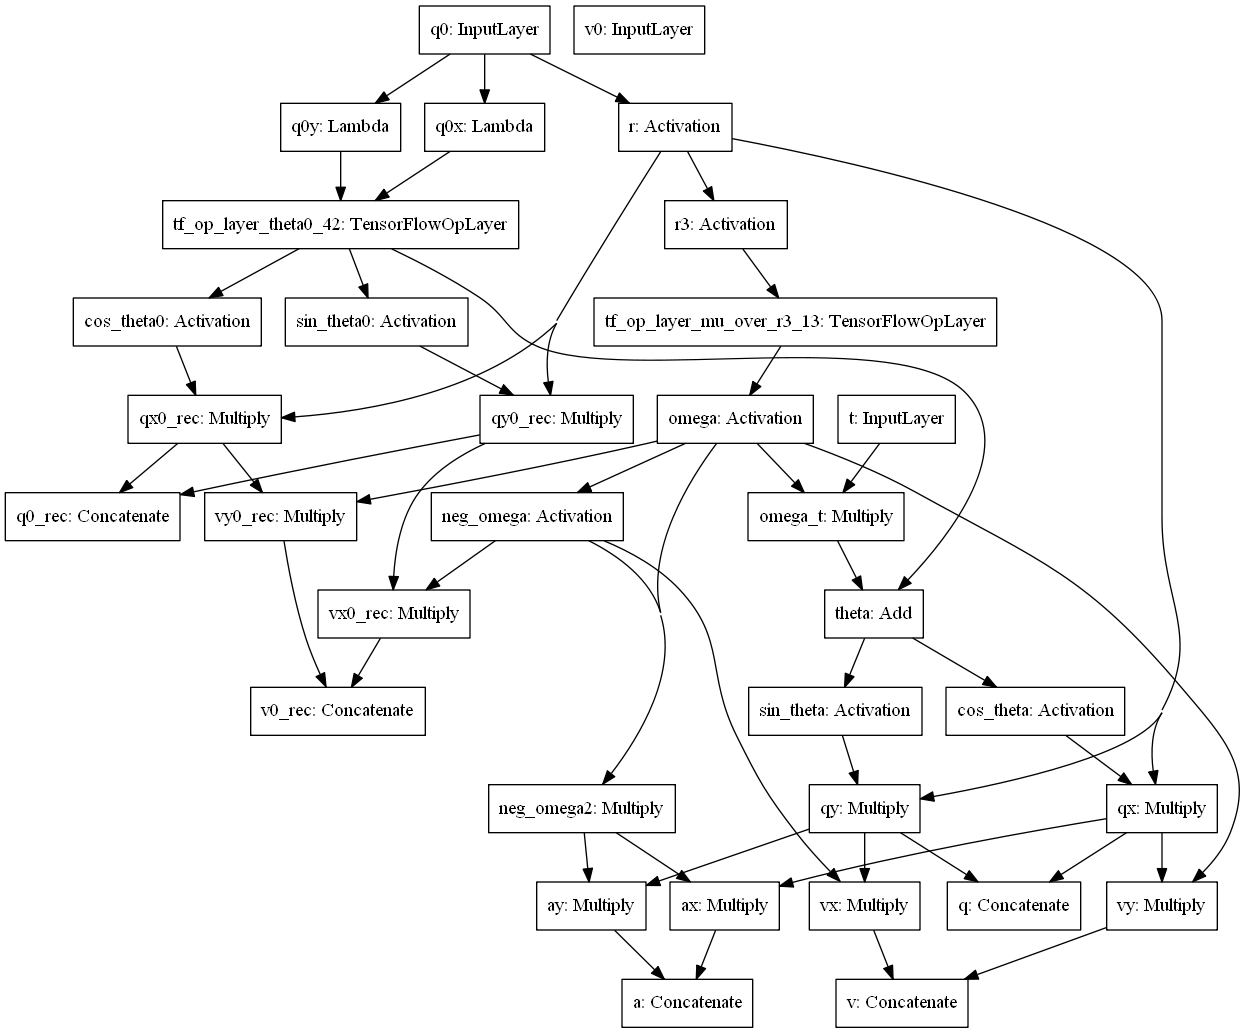

In [304]:
keras.utils.plot_model(model0, show_shapes=False)

In [213]:
model0.summary()

Model: "r2bc_analytic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
t (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_omega_14/Shape (Ten [(2,)]               0           t[0][0]                          
__________________________________________________________________________________________________
tf_op_layer_omega_14 (TensorFlo [(None, 1)]          0           tf_op_layer_omega_14/Shape[0][0] 
__________________________________________________________________________________________________
q0 (InputLayer)                 [(None, 2)]          0                                            
______________________________________________________________________________________

In [209]:
filepath = '../models/r2bc_analytic_{epoch}.h5'
callback_ckp = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1)

log_dir = '../logs/'
callback_tb = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    embeddings_freq=0,
    update_freq='epoch')

callbacks = [callback_ckp]

In [210]:
history_earth = model0.fit(ds_earth_trn, epochs=3, callbacks=None, validation_data = ds_earth_val)

Epoch 1/3
286/286 [==============================] - 3s 12ms/step - loss: 2.3006e-11 - q_loss: 9.4349e-15 - v_loss: 3.7650e-13 - a_loss: 2.2551e-11 - q0_rec_loss: 1.7391e-15 - v0_rec_loss: 6.7743e-14 - val_loss: 3.8957e-11 - val_q_loss: 1.9456e-14 - val_v_loss: 7.7276e-13 - val_a_loss: 3.8072e-11 - val_q0_rec_loss: 2.4529e-15 - val_v0_rec_loss: 9.0636e-14
Epoch 2/3
286/286 [==============================] - 2s 9ms/step - loss: 2.3006e-11 - q_loss: 9.4349e-15 - v_loss: 3.7650e-13 - a_loss: 2.2551e-11 - q0_rec_loss: 1.7391e-15 - v0_rec_loss: 6.7743e-14 - val_loss: 3.8957e-11 - val_q_loss: 1.9456e-14 - val_v_loss: 7.7276e-13 - val_a_loss: 3.8072e-11 - val_q0_rec_loss: 2.4529e-15 - val_v0_rec_loss: 9.0636e-14
Epoch 3/3
286/286 [==============================] - 2s 8ms/step - loss: 2.3006e-11 - q_loss: 9.4349e-15 - v_loss: 3.7650e-13 - a_loss: 2.2551e-11 - q0_rec_loss: 1.7391e-15 - v0_rec_loss: 6.7743e-14 - val_loss: 3.8957e-11 - val_q_loss: 1.9456e-14 - val_v_loss: 7.7276e-13 - val_a_loss:

In [158]:
model0.evaluate(inputs_earth, outputs_earth)

731/731 [==============================] - 0s 236us/sample - loss: 8.0984e-12 - q_loss: 3.0170e-16 - v_loss: 1.5611e-14 - a_loss: 8.0799e-12 - q0_rec_loss: 0.0000e+00 - v0_rec_loss: 0.0000e+00


[8.098420675559449e-12, 3.0170488e-16, 1.5610841e-14, 8.079863e-12, 0.0, 0.0]

In [61]:
def make_model_r2bc():
    """Create a model for the restricted two body circular problem"""
    # Create input layers
    t = keras.Input(shape=(1,), name='t')
    q0 = keras.Input(shape=(2,), name='q0')
    v0 = keras.Input(shape=(2,), name='v0')
    # The combined input layers
    inputs = [t, q0, v0]
    
    # Combine the input features for the initial configuration
    config0 = keras.layers.concatenate(inputs=[q0, v0], name='config0') 

    # 2 Dense feature layers depending ONLY on the configuration (not the time)
    x1 = keras.layers.Dense(units=16, activation='tanh', name='x1')(config0)
    x2 = keras.layers.Dense(units=16, activation='tanh', name='x2')(x1)
    
    # The radius r; this is the same at time 0 and t because x2 does not depend on t
    r = keras.layers.Dense(1, name='r')(x2)
  
    # The angular velocity omega
    omega = keras.layers.Dense(1, name='omega')(x2)
    
    # Negative of omega and omega2; used below for computing the velocity and acceleration components
    neg_omega = keras.layers.Activation(activation=tf.negative, name='neg_omega')(omega)
    neg_omega2 = keras.layers.multiply(inputs=[neg_omega, omega], name='neg_omega2')
    
    # The initial angle theta_0
    theta0 = keras.layers.Dense(1, name='theta0')(x2)
    
    # The angle theta at time t
    # theta = omega * t + theta0
    omega_t = keras.layers.multiply(inputs=[omega, t], name='omega_t')
    theta = keras.layers.add(inputs=[omega_t, theta0], name='theta')
    
    # Cosine and sine of theta
    cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
    sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

    # Compute qx and qy from r, theta
    # qx = r cos(theta)
    # qy = r sin(theta)
    qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
    qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
    q = keras.layers.concatenate(inputs=[qx, qy], name='q')
    
    # Compute vx and vy from r, theta
    # TODO: generalize derivative computation using GradientTape
    # vx = -omega qy
    # vy = +omega qx
    vx = keras.layers.multiply(inputs=[neg_omega, qy], name='vx')
    vy = keras.layers.multiply(inputs=[omega, qx], name='vy')
    v = keras.layers.concatenate(inputs=[vx, vy], name='v')

    # Compute ax and ay from r, theta
    # TODO: generalize derivative computation using GradientTape
    # ax = - omega^2 qx
    # ay = - omega^2 qy
    ax = keras.layers.multiply(inputs=[neg_omega2, qx], name='ax')
    ay = keras.layers.multiply(inputs=[neg_omega2, qy], name='ay')
    a = keras.layers.concatenate(inputs=[ax, ay], name='a')

    # The sine and cosine of theta0 are used for the recovered initial configuration
    cos_theta0 = keras.layers.Activation(activation=tf.cos, name='cos_theta0')(theta0)
    sin_theta0 = keras.layers.Activation(activation=tf.sin, name='sin_theta0')(theta0)

    # The recovered initial position q0_rec
    qx0_rec = keras.layers.multiply(inputs=[r, cos_theta0], name='qx0_rec')
    qy0_rec = keras.layers.multiply(inputs=[r, sin_theta0], name='qy0_rec')
    q0_rec = keras.layers.concatenate(inputs=[qx0_rec, qy0_rec], name='q0_rec')

    # The recovered initial velocity v0_rec
    vx0_rec = keras.layers.multiply(inputs=[neg_omega, qy0_rec], name='vx0_rec')
    vy0_rec = keras.layers.multiply(inputs=[omega, qx0_rec], name='vy0_rec')
    v0_rec = keras.layers.concatenate(inputs=[vx0_rec, vy0_rec], name='v0_rec')       

    # The combined output layers
    outputs = [q, v, a, q0_rec, v0_rec]
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='r2bc')
    return model

In [ ]:
history_earth.history.keys()